In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
!pip install dive-into-graphs
!pip install pydig

1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import numpy as np
from termcolor import colored
from torch._C import dtype
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GNNExplainer
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K

from dig.xgraph.models import GCN_2l

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#def visualize(h, color):
#    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
#
#    plt.figure(figsize=(10,10))
#    plt.xticks([])
#    plt.yticks([])
#
#    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
#    plt.show()

In [5]:
Explainability_name = 'Comparison of GNNExplainer and PGExplainer'
Task_name = 'Node Classification'
checkpoint_directory_Classifier_GNNE = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier_GNNE.pt"
checkpoint_directory_Classifier_PGE = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier_PGE.pt"

In [6]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
#dataset = SynGraphDataset('./datasets', 'BA_shapes')

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
#print(np.shape(dataset))
print(data)
print(colored('===========================================================================================================', 'red'))


# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Number of val nodes: {data.val_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Number of test nodes: 1000
Number of val nodes: 500
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [7]:
print(len(data.x[0]))
print(len(data.x))
print(len(data.y))
print(data.y[0])
print(f'MAX: {max(data.y)}')
print(f'MIN: {min(data.y)}')
print(data.x[0])
print(len(data.edge_index[0]))
print("-------------------------------------")


1433
2708
2708
tensor(3)
MAX: 6
MIN: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])
10556
-------------------------------------


In [8]:
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

In [9]:
def split_dataset(dataset):
    indices = []
    train_percent = 0.7

    num_classes = dataset.num_classes
    
    for i in range(num_classes):
        index = (dataset.data.y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)

    train_index = torch.cat([i[:int(len(i) * train_percent)] for i in indices], dim=0)
    rest_index = torch.cat([i[int(len(i) * train_percent):] for i in indices], dim=0)

    #print(len(train_index.tolist()), len(rest_index.tolist()))

    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    dataset.data.train_mask = index_to_mask(train_index, size=dataset.data.num_nodes)
    dataset.data.test_mask = index_to_mask(rest_index, size=dataset.data.num_nodes)

    dataset.data, dataset.slices = dataset.collate([dataset.data])

    return dataset
    #return train_index, rest_index

In [10]:
One_Graph_dataset = split_dataset(dataset)
dataset_PGE_vs_GNNE = One_Graph_dataset[0]
print(dataset_PGE_vs_GNNE)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


# **GCN MODEL**

In [11]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

GCN_Model_GNNE = GCN(hidden_channels=16)
print(GCN_Model_GNNE)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [12]:
#GCN_Model_GNNE = GCN_2l(model_level='node', dim_node=1433, dim_hidden=100, num_classes=7)
#print(GCN_Model_GNNE)

In [13]:
GCN_Model_GNNE_Optimizer = torch.optim.Adam(GCN_Model_GNNE.parameters(), lr=0.01, weight_decay=5e-4)

In [14]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [15]:
def loading_model(load_index):
  GCN_Model_GNNE = GCN(model_level='node', dim_node=1433, dim_hidden=100, num_classes=7)
  GCN_Model_GNNE_Optimizer = torch.optim.Adam(params = GCN_Model_GNNE.parameters(), lr=0.01)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  GCN_Model_GNNE.load_state_dict(checkpoint['model_state_dict'])
  GCN_Model_GNNE.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GCN_Model_GNNE, GCN_Model_GNNE_Optimizer, epoch

In [16]:
def GNNE_visualize_losses(gcn_losses, epoch_history):
  gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("`GCN Model Loss in Epoch: " + str(epoch_history))
  ax.plot(gcn_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'GNNE_Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Training GNN for GNNE**

In [17]:
def train_step_GNNE():
  GCN_Model_GNNE.train(True)

  GCN_Model_GNNE_Optimizer.zero_grad()  
  GCN_Model_GNNE_out = GCN_Model_GNNE(dataset_PGE_vs_GNNE.x, dataset_PGE_vs_GNNE.edge_index)  

  GCN_Model_GNNE_loss = loss_calculations(GCN_Model_GNNE_out[dataset_PGE_vs_GNNE.train_mask], dataset_PGE_vs_GNNE.y[dataset_PGE_vs_GNNE.train_mask])  
  GCN_Model_GNNE_loss.backward(retain_graph=True)

  GCN_Model_GNNE_Optimizer.step()    


  return GCN_Model_GNNE_loss


In [18]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [19]:
def train_GNNE(EPOCHS, load_index):
  GCN_Model_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    GCN_Model_training_loss= train_step_GNNE()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GCN_Model_training_loss:.4f}')

    GCN_Model_training_loss_per_epoch.append(GCN_Model_training_loss)

    #break

    if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
      GNNE_visualize_losses(GCN_Model_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GCN_Model_GNNE.state_dict(), 'optimizer_state_dict': GCN_Model_GNNE_Optimizer.state_dict(), 'loss': GCN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  

Epoch: 001, Comparison of GNNExplainer and PGExplainer Model Loss: 1.9469
Epoch: 002, Comparison of GNNExplainer and PGExplainer Model Loss: 1.9373
Epoch: 003, Comparison of GNNExplainer and PGExplainer Model Loss: 1.9287
Epoch: 004, Comparison of GNNExplainer and PGExplainer Model Loss: 1.9176
Epoch: 005, Comparison of GNNExplainer and PGExplainer Model Loss: 1.9072
Epoch: 006, Comparison of GNNExplainer and PGExplainer Model Loss: 1.8966
Epoch: 007, Comparison of GNNExplainer and PGExplainer Model Loss: 1.8864
Epoch: 008, Comparison of GNNExplainer and PGExplainer Model Loss: 1.8733
Epoch: 009, Comparison of GNNExplainer and PGExplainer Model Loss: 1.8620
Epoch: 010, Comparison of GNNExplainer and PGExplainer Model Loss: 1.8522
Epoch: 011, Comparison of GNNExplainer and PGExplainer Model Loss: 1.8373
Epoch: 012, Comparison of GNNExplainer and PGExplainer Model Loss: 1.8305
Epoch: 013, Comparison of GNNExplainer and PGExplainer Model Loss: 1.8176
Epoch: 014, Comparison of GNNExplainer

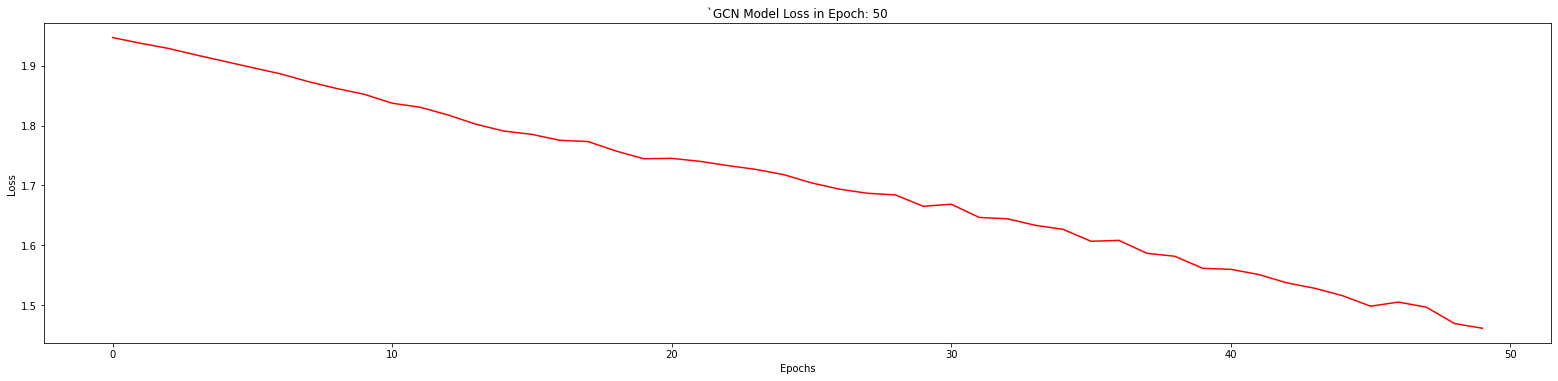

Epoch: 051, Comparison of GNNExplainer and PGExplainer Model Loss: 1.4593
Epoch: 052, Comparison of GNNExplainer and PGExplainer Model Loss: 1.4420
Epoch: 053, Comparison of GNNExplainer and PGExplainer Model Loss: 1.4331
Epoch: 054, Comparison of GNNExplainer and PGExplainer Model Loss: 1.4244
Epoch: 055, Comparison of GNNExplainer and PGExplainer Model Loss: 1.4140
Epoch: 056, Comparison of GNNExplainer and PGExplainer Model Loss: 1.4038
Epoch: 057, Comparison of GNNExplainer and PGExplainer Model Loss: 1.3878
Epoch: 058, Comparison of GNNExplainer and PGExplainer Model Loss: 1.3811
Epoch: 059, Comparison of GNNExplainer and PGExplainer Model Loss: 1.3722
Epoch: 060, Comparison of GNNExplainer and PGExplainer Model Loss: 1.3558
Epoch: 061, Comparison of GNNExplainer and PGExplainer Model Loss: 1.3624
Epoch: 062, Comparison of GNNExplainer and PGExplainer Model Loss: 1.3367
Epoch: 063, Comparison of GNNExplainer and PGExplainer Model Loss: 1.3397
Epoch: 064, Comparison of GNNExplainer

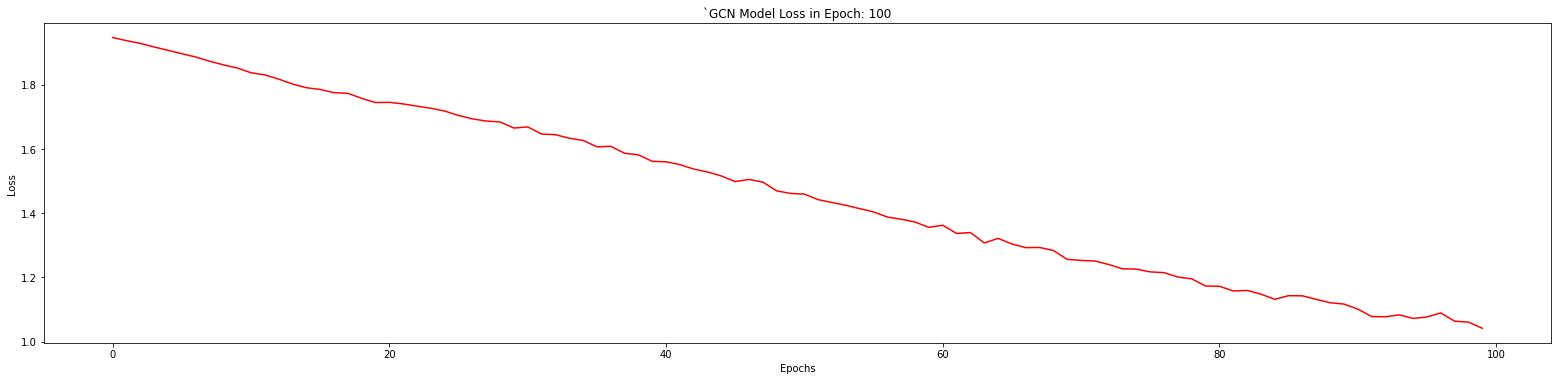

Epoch: 101, Comparison of GNNExplainer and PGExplainer Model Loss: 1.0482
Epoch: 102, Comparison of GNNExplainer and PGExplainer Model Loss: 1.0455
Epoch: 103, Comparison of GNNExplainer and PGExplainer Model Loss: 1.0151
Epoch: 104, Comparison of GNNExplainer and PGExplainer Model Loss: 1.0249
Epoch: 105, Comparison of GNNExplainer and PGExplainer Model Loss: 1.0256
Epoch: 106, Comparison of GNNExplainer and PGExplainer Model Loss: 1.0217
Epoch: 107, Comparison of GNNExplainer and PGExplainer Model Loss: 1.0279
Epoch: 108, Comparison of GNNExplainer and PGExplainer Model Loss: 1.0116
Epoch: 109, Comparison of GNNExplainer and PGExplainer Model Loss: 0.9843
Epoch: 110, Comparison of GNNExplainer and PGExplainer Model Loss: 0.9822
Epoch: 111, Comparison of GNNExplainer and PGExplainer Model Loss: 0.9843
Epoch: 112, Comparison of GNNExplainer and PGExplainer Model Loss: 0.9819
Epoch: 113, Comparison of GNNExplainer and PGExplainer Model Loss: 0.9721
Epoch: 114, Comparison of GNNExplainer

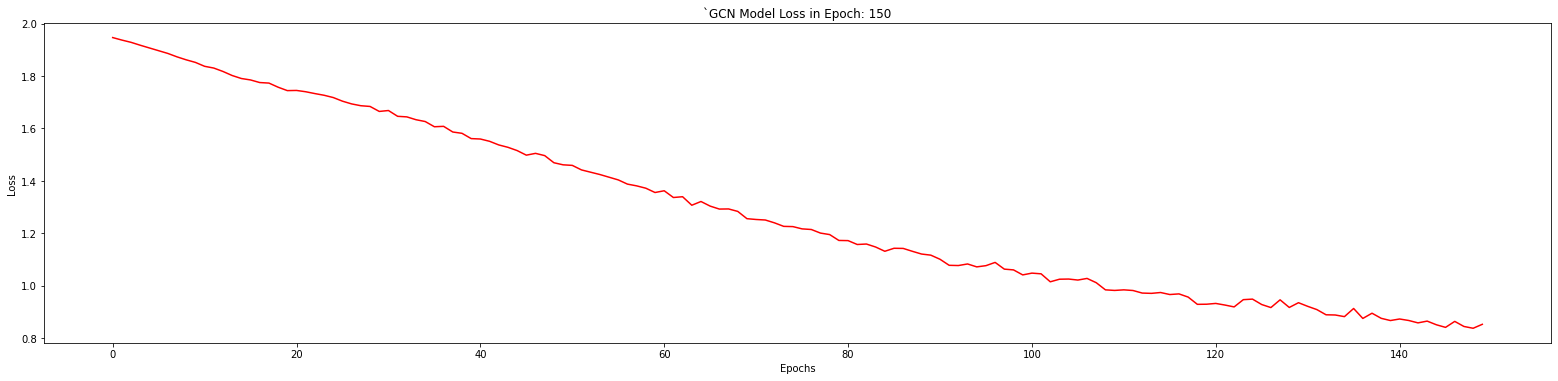

Epoch: 151, Comparison of GNNExplainer and PGExplainer Model Loss: 0.8344
Epoch: 152, Comparison of GNNExplainer and PGExplainer Model Loss: 0.8371
Epoch: 153, Comparison of GNNExplainer and PGExplainer Model Loss: 0.8524
Epoch: 154, Comparison of GNNExplainer and PGExplainer Model Loss: 0.8221
Epoch: 155, Comparison of GNNExplainer and PGExplainer Model Loss: 0.8403
Epoch: 156, Comparison of GNNExplainer and PGExplainer Model Loss: 0.8312
Epoch: 157, Comparison of GNNExplainer and PGExplainer Model Loss: 0.8267
Epoch: 158, Comparison of GNNExplainer and PGExplainer Model Loss: 0.8250
Epoch: 159, Comparison of GNNExplainer and PGExplainer Model Loss: 0.8247
Epoch: 160, Comparison of GNNExplainer and PGExplainer Model Loss: 0.8185
Epoch: 161, Comparison of GNNExplainer and PGExplainer Model Loss: 0.7996
Epoch: 162, Comparison of GNNExplainer and PGExplainer Model Loss: 0.8266
Epoch: 163, Comparison of GNNExplainer and PGExplainer Model Loss: 0.8223
Epoch: 164, Comparison of GNNExplainer

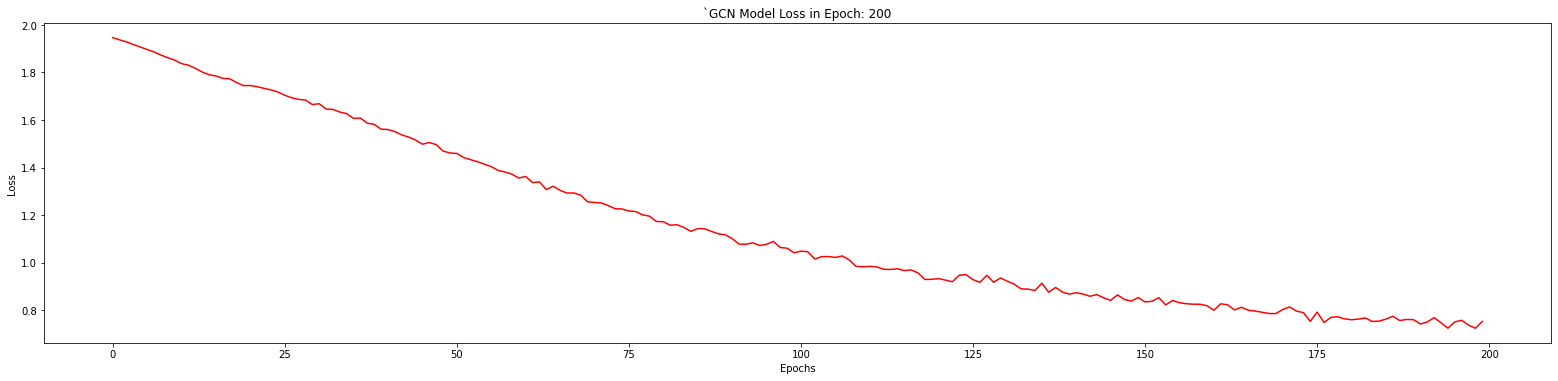

In [20]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
train_GNNE(EPOCHS, load_index)

In [21]:
def GCN_Model_GNNE_test():
  GCN_Model_GNNE.eval()
  GCN_Model_GNNE_out = GCN_Model_GNNE(dataset_PGE_vs_GNNE.x, dataset_PGE_vs_GNNE.edge_index)
  GCN_Model_GNNE_pred = GCN_Model_GNNE_out.argmax(dim=1) 
  GCN_Model_GNNE_test_correct = GCN_Model_GNNE_pred[dataset_PGE_vs_GNNE.test_mask] == dataset_PGE_vs_GNNE.y[dataset_PGE_vs_GNNE.test_mask] 
  GCN_Model_GNNE_test_acc = int(GCN_Model_GNNE_test_correct.sum()) / int(dataset_PGE_vs_GNNE.test_mask.sum())
  return GCN_Model_GNNE_test_acc


In [22]:
GCN_Model_GNNE_test_acc = GCN_Model_GNNE_test()
print(f'Test Accuracy: {GCN_Model_GNNE_test_acc:.4f}')

Test Accuracy: 0.8739


# **GNNExplainer**

In [146]:
training_node_masks = []
training_edge_masks = []

#node_idx = 10
#x, edge_index = data.x, data.edge_index
gnne_explainer = GNNExplainer(GCN_Model_GNNE, epochs=1)
print(len(dataset_PGE_vs_GNNE.x[dataset_PGE_vs_GNNE.train_mask]))

1891


In [147]:
train_index_list = []
for i in range(len(dataset_PGE_vs_GNNE.train_mask)):
  if dataset_PGE_vs_GNNE.train_mask[i]:
    train_index_list.append(i)

## **Edge index list for training**

In [148]:
print(len(train_index_list))
training_edge_index_start = []
training_edge_index_end = []


1891


In [149]:
for i in range(len(train_index_list)):
  index = (dataset_PGE_vs_GNNE.edge_index[0] == train_index_list[i]).nonzero().view(-1)
  #index = index[torch.randperm(index.size(0))]
  #index = [tensor.item() for tensor in index]
  #print(index)
  for j in index:
    origin = dataset_PGE_vs_GNNE.edge_index[0][j].detach().cpu().numpy()
    origin = origin.tolist()
    #index = [tensor.item() for tensor in first]
    training_edge_index_start.append(origin)

    destination = dataset_PGE_vs_GNNE.edge_index[1][j].detach().cpu().numpy()
    destination = destination.tolist()
    training_edge_index_end.append(destination)

In [150]:

print(training_edge_index_start)
print(training_edge_index_end)

print(len(training_edge_index_start))
print(len(training_edge_index_end))


[0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 9, 9, 10, 10, 11, 11, 12, 12, 12, 12, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 20, 20, 20, 20, 20, 21, 21, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 28, 30, 30, 30, 30, 30, 30, 31, 32, 32, 32, 32, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 44, 44, 44, 45, 45, 45, 45, 45, 45, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 50, 52, 52, 52, 52, 52, 53, 53, 53, 54, 54, 56, 56, 56, 56, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 61, 61, 61, 61, 61, 62, 63, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 67, 67, 67, 70, 70, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 76, 76, 76, 77, 77, 78, 78, 78, 80, 80, 80, 81, 81, 81, 81, 83, 83, 84, 84, 84, 84, 84, 85, 85, 85, 86, 86, 86, 86, 87, 87, 87, 88, 8

In [151]:
print(type(dataset_PGE_vs_GNNE.edge_index))
print(len(dataset_PGE_vs_GNNE.x[dataset_PGE_vs_GNNE.train_mask]))

<class 'torch.Tensor'>
1891


In [152]:
#from dig.xgraph.method import GNNExplainer
for i in train_index_list:
  node_feat_mask, edge_mask = gnne_explainer.explain_node(i, dataset_PGE_vs_GNNE.x, torch.tensor([training_edge_index_start,training_edge_index_end]))
  training_node_masks.append(node_feat_mask)
  training_edge_masks.append(edge_mask)



Explain node 2707: 100%|██████████| 1/1 [00:00<00:00, 117.94it/s]


## **GNNE done now work on details**

In [153]:
print("Number of Edges = ",len(training_edge_masks[0]))
print("Number of Nodes = ",len(training_edge_masks))
print(training_edge_masks)

print("Number of Atts = ",len(training_node_masks[0]))
print("Number of Nodes = ",len(training_node_masks))
print(training_node_masks)


Training_Edge_Masks = []
Training_Node_Masks = []

for i in range(len(training_edge_masks)):
  T_E_M = training_edge_masks[i].detach().cpu().numpy()
  Training_Edge_Masks.append(T_E_M.tolist())

  T_N_M = training_node_masks[i].detach().cpu().numpy()
  Training_Node_Masks.append(T_N_M.tolist())

Number of Edges =  7511
Number of Nodes =  1891
[tensor([0.6306, 0.0000, 0.6158,  ..., 0.0000, 0.0000, 0.0000]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0.0000, 0.0000, 0.0000,  ..., 0.5344, 0.4974, 0.0000]), tensor([0., 0., 0.,  ..

In [154]:
print("Number of Edges = ",len(Training_Edge_Masks[0]))
print("Number of Nodes = ",len(Training_Edge_Masks))

print("Number of Atts = ",len(Training_Node_Masks[0]))
print("Number of Nodes = ",len(Training_Node_Masks))

Number of Edges =  7511
Number of Nodes =  1891
Number of Atts =  1433
Number of Nodes =  1891


In [111]:
print(training_edge_index_start)
print(training_edge_index_end)

[0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 9, 9, 10, 10, 11, 11, 12, 12, 12, 12, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 20, 20, 20, 20, 20, 21, 21, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 28, 30, 30, 30, 30, 30, 30, 31, 32, 32, 32, 32, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 44, 44, 44, 45, 45, 45, 45, 45, 45, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 50, 52, 52, 52, 52, 52, 53, 53, 53, 54, 54, 56, 56, 56, 56, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 61, 61, 61, 61, 61, 62, 63, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 67, 67, 67, 70, 70, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 76, 76, 76, 77, 77, 78, 78, 78, 80, 80, 80, 81, 81, 81, 81, 83, 83, 84, 84, 84, 84, 84, 85, 85, 85, 86, 86, 86, 86, 87, 87, 87, 88, 8

In [27]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from termcolor import colored
from torch._C import dtype

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear
from sklearn.model_selection import train_test_split
import numpy as np

from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
import tensorflow as tf
from torch_geometric.nn import GCNConv, GNNExplainer

#. DGL
import dgl
import dgl.function as fn
from dgl.data import GINDataset
#from dgl.nn import GNNExplainer as GNNExplainer_DGL
from dgl.dataloading import GraphDataLoader
from dgl.nn import AvgPooling
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import TUDataset


#. DIG
from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.method import PGExplainer
from dig.xgraph.utils.compatibility import compatible_state_dict
from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import MCTS
from torch_geometric.utils import to_networkx
#from dig.xgraph.method import GNNExplainer as GNNExplainer_DIG
from dig.xgraph.models import GCN_2l

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [28]:
GCN_Model_PGE = GCN_2l(model_level='node', dim_node=1433, dim_hidden=100, num_classes=7)
print(GCN_Model_PGE)
#GCN_Model = GCN(16)
GCN_Model_PGE.eval()

#out = GCN_Model(dataset_PGE_vs_GNNE.x, dataset_PGE_vs_GNNE.edge_index)
#visualize(out, color=data.y)


GCN_2l(
  (conv1): GCNConv(1433, 100)
  (convs): ModuleList(
    (0): GCNConv(100, 100)
  )
  (relu1): ReLU()
  (relus): ModuleList(
    (0): ReLU()
  )
  (readout): IdenticalPool()
  (ffn): Sequential(
    (0): Linear(in_features=100, out_features=7, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


GCN_2l(
  (conv1): GCNConv(1433, 100)
  (convs): ModuleList(
    (0): GCNConv(100, 100)
  )
  (relu1): ReLU()
  (relus): ModuleList(
    (0): ReLU()
  )
  (readout): IdenticalPool()
  (ffn): Sequential(
    (0): Linear(in_features=100, out_features=7, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

In [29]:
GCN_Model_PGE_Optimizer = torch.optim.Adam(GCN_Model_PGE.parameters(), lr=0.01, weight_decay=5e-4)

In [30]:
def PGE_visualize_losses(gcn_losses, epoch_history):
  gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("`GCN Model Loss in Epoch: " + str(epoch_history))
  ax.plot(gcn_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'PGE_Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Training GNN for PGE**

In [31]:


def train_step_PGE():
  GCN_Model_PGE.train(True)

  GCN_Model_PGE_Optimizer.zero_grad()  
  GCN_Model_PGE_out = GCN_Model_PGE(dataset_PGE_vs_GNNE.x, dataset_PGE_vs_GNNE.edge_index)  

  GCN_Model_PGE_loss = loss_calculations(GCN_Model_PGE_out[dataset_PGE_vs_GNNE.train_mask], dataset_PGE_vs_GNNE.y[dataset_PGE_vs_GNNE.train_mask])  
  GCN_Model_PGE_loss.backward(retain_graph=True)

  GCN_Model_PGE_Optimizer.step()    


  return GCN_Model_PGE_loss



In [32]:
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

def train_PGE(EPOCHS, load_index):
  GCN_Model_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    GCN_Model_training_loss= train_step_PGE()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GCN_Model_training_loss:.4f}')

    GCN_Model_training_loss_per_epoch.append(GCN_Model_training_loss)

    #break

    if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
      PGE_visualize_losses(GCN_Model_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GCN_Model_PGE.state_dict(), 'optimizer_state_dict': GCN_Model_PGE_Optimizer.state_dict(), 'loss': GCN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  




Epoch: 001, Comparison of GNNExplainer and PGExplainer Model Loss: 1.9692
Epoch: 002, Comparison of GNNExplainer and PGExplainer Model Loss: 1.9561
Epoch: 003, Comparison of GNNExplainer and PGExplainer Model Loss: 1.9357
Epoch: 004, Comparison of GNNExplainer and PGExplainer Model Loss: 1.9068
Epoch: 005, Comparison of GNNExplainer and PGExplainer Model Loss: 1.8706
Epoch: 006, Comparison of GNNExplainer and PGExplainer Model Loss: 1.8345
Epoch: 007, Comparison of GNNExplainer and PGExplainer Model Loss: 1.8134
Epoch: 008, Comparison of GNNExplainer and PGExplainer Model Loss: 1.8146
Epoch: 009, Comparison of GNNExplainer and PGExplainer Model Loss: 1.8022
Epoch: 010, Comparison of GNNExplainer and PGExplainer Model Loss: 1.7774
Epoch: 011, Comparison of GNNExplainer and PGExplainer Model Loss: 1.7569
Epoch: 012, Comparison of GNNExplainer and PGExplainer Model Loss: 1.7423
Epoch: 013, Comparison of GNNExplainer and PGExplainer Model Loss: 1.7270
Epoch: 014, Comparison of GNNExplainer

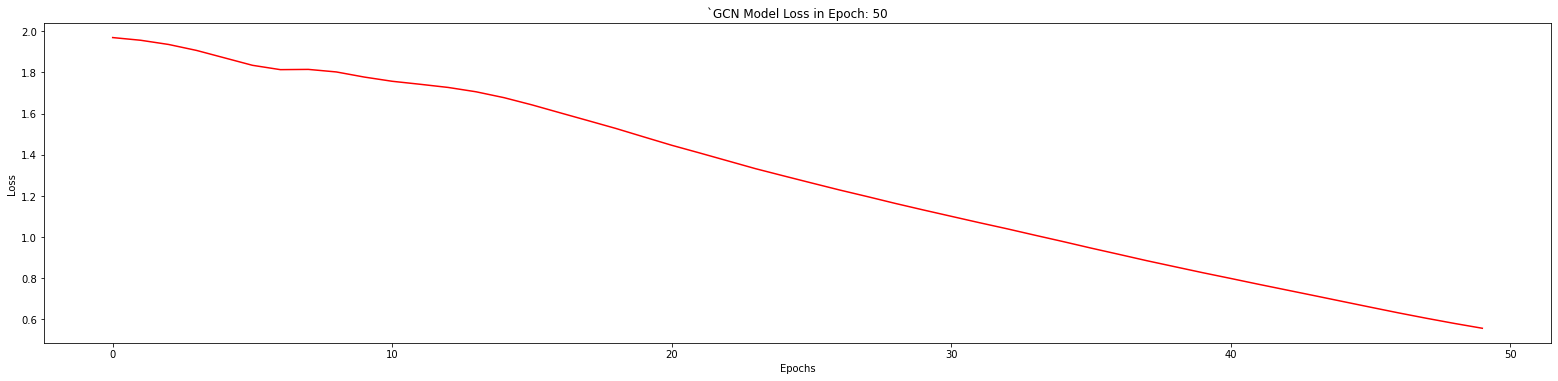

Epoch: 051, Comparison of GNNExplainer and PGExplainer Model Loss: 0.5348
Epoch: 052, Comparison of GNNExplainer and PGExplainer Model Loss: 0.5135
Epoch: 053, Comparison of GNNExplainer and PGExplainer Model Loss: 0.4931
Epoch: 054, Comparison of GNNExplainer and PGExplainer Model Loss: 0.4734
Epoch: 055, Comparison of GNNExplainer and PGExplainer Model Loss: 0.4550
Epoch: 056, Comparison of GNNExplainer and PGExplainer Model Loss: 0.4381
Epoch: 057, Comparison of GNNExplainer and PGExplainer Model Loss: 0.4224
Epoch: 058, Comparison of GNNExplainer and PGExplainer Model Loss: 0.4077
Epoch: 059, Comparison of GNNExplainer and PGExplainer Model Loss: 0.3936
Epoch: 060, Comparison of GNNExplainer and PGExplainer Model Loss: 0.3796
Epoch: 061, Comparison of GNNExplainer and PGExplainer Model Loss: 0.3664
Epoch: 062, Comparison of GNNExplainer and PGExplainer Model Loss: 0.3544
Epoch: 063, Comparison of GNNExplainer and PGExplainer Model Loss: 0.3434
Epoch: 064, Comparison of GNNExplainer

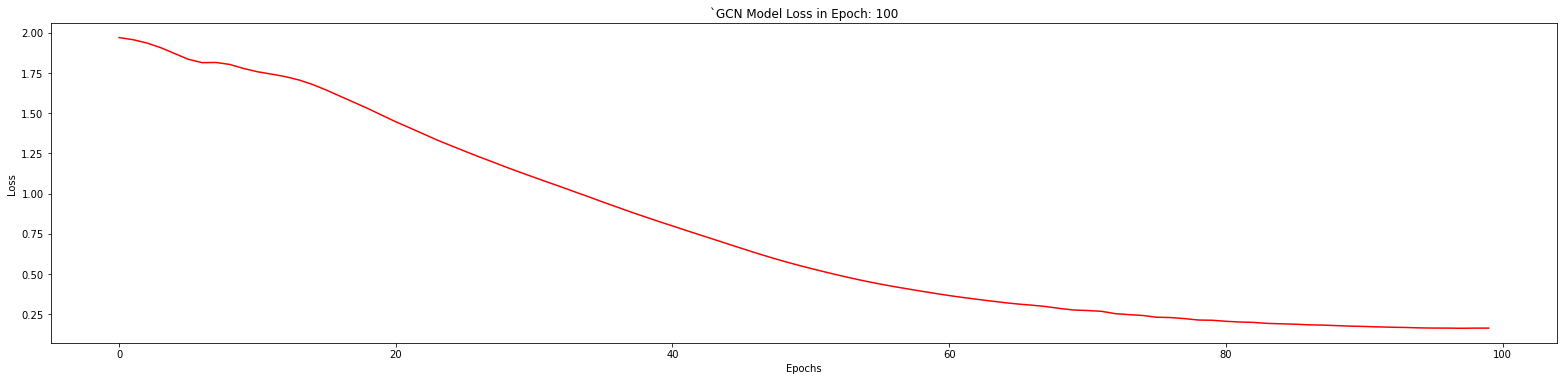

Epoch: 101, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1595
Epoch: 102, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1545
Epoch: 103, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1540
Epoch: 104, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1545
Epoch: 105, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1534
Epoch: 106, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1507
Epoch: 107, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1482
Epoch: 108, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1491
Epoch: 109, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1492
Epoch: 110, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1464
Epoch: 111, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1455
Epoch: 112, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1453
Epoch: 113, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1442
Epoch: 114, Comparison of GNNExplainer

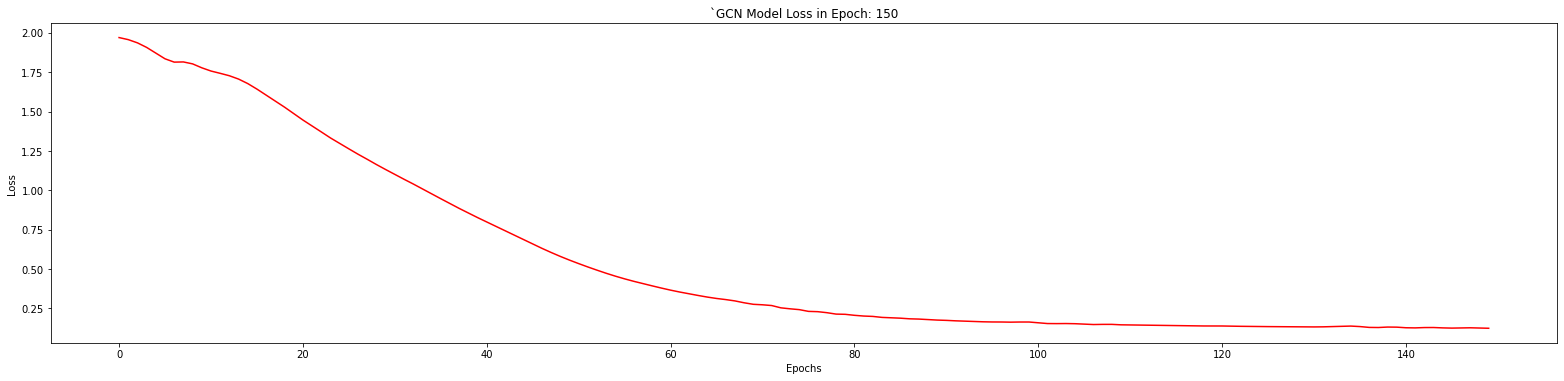

Epoch: 151, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1247
Epoch: 152, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1255
Epoch: 153, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1252
Epoch: 154, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1239
Epoch: 155, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1232
Epoch: 156, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1235
Epoch: 157, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1238
Epoch: 158, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1235
Epoch: 159, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1228
Epoch: 160, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1223
Epoch: 161, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1228
Epoch: 162, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1246
Epoch: 163, Comparison of GNNExplainer and PGExplainer Model Loss: 0.1276
Epoch: 164, Comparison of GNNExplainer

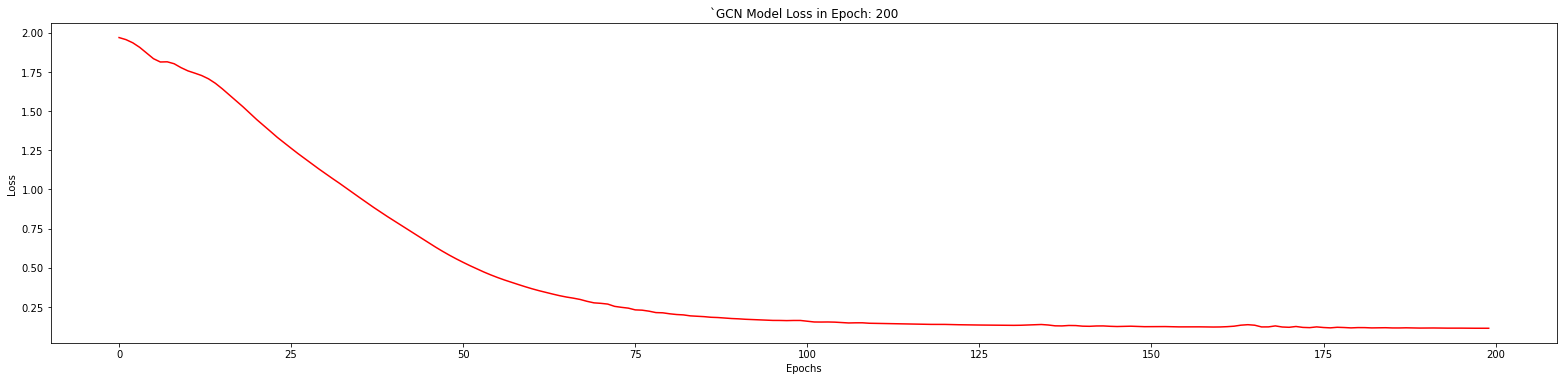

In [33]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
train_PGE(EPOCHS, load_index)

# **Test Configuration for the Model**

In [34]:
def GCN_Model_PGE_test():
  GCN_Model_PGE.eval()
  GCN_Model_PGE_out = GCN_Model_PGE(dataset_PGE_vs_GNNE.x, dataset_PGE_vs_GNNE.edge_index)
  GCN_Model_PGE_pred = GCN_Model_PGE_out.argmax(dim=1) 
  GCN_Model_PGE_test_correct = GCN_Model_PGE_pred[dataset_PGE_vs_GNNE.test_mask] == dataset_PGE_vs_GNNE.y[dataset_PGE_vs_GNNE.test_mask] 
  GCN_Model_PGE_test_acc = int(GCN_Model_PGE_test_correct.sum()) / int(dataset_PGE_vs_GNNE.test_mask.sum())
  return GCN_Model_PGE_test_acc

In [35]:
GCN_Model_PGE_test_acc = GCN_Model_PGE_test()
print(f'Test Accuracy: {GCN_Model_PGE_test_acc:.4f}')

Test Accuracy: 0.8641


In [35]:
#GCN_Model_PGE.eval()

#GCN_Model_test_out = GCN_Model(dataset_PGE_vs_GNNE.x, dataset_PGE_vs_GNNE.edge_index)
#visualize(GCN_Model_test_out, color = dataset_PGE_vs_GNNE.y)

GCN_2l(
  (conv1): GCNConv(1433, 100)
  (convs): ModuleList(
    (0): GCNConv(100, 100)
  )
  (relu1): ReLU()
  (relus): ModuleList(
    (0): ReLU()
  )
  (readout): IdenticalPool()
  (ffn): Sequential(
    (0): Linear(in_features=100, out_features=7, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

# **PGExplainer**


In [36]:
import os
import os.path as osp

import torch
from torch_geometric.data import DataLoader
from torch_geometric.data import download_url, extract_zip

from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.models import *
from dig.xgraph.utils.compatibility import compatible_state_dict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [37]:
from dig.xgraph.method import PGExplainer

PGE_Explainer = PGExplainer(GCN_Model_PGE, in_channels=300, device=device, explain_graph=False, num_hops=1, epochs=1)

PGE_Explainer.train_explanation_network(One_Graph_dataset)
#torch.save(PGE_Explainer.state_dict(), 'tmp.pt')
#state_dict = torch.load('tmp.pt')
#PGE_Explainer.load_state_dict(state_dict)


100%|██████████| 1891/1891 [00:00<00:00, 114210.02it/s]
1891it [10:12,  3.09it/s]

Epoch: 0 | Loss: 0.3604180877097444
training time is 612.18s


In [79]:
PGE_Masks = []
for i in range(len(dataset_PGE_vs_GNNE)):
  with torch.no_grad():
    walks, masks, related_preds = PGE_Explainer(dataset_PGE_vs_GNNE.x, dataset_PGE_vs_GNNE.edge_index, node_idx=i, y=dataset_PGE_vs_GNNE.y)
    print(i)
    #print(masks[0])

    #for mask in masks:
    PGE_Masks.append(masks[0].detach().numpy().tolist())
    #print(PGE_Masks)


0
1
2
3
4
5


In [52]:
print(len(PGE_Masks))
print(len(Edge_Masks))
print(len(Node_Masks))

2708
2708
2708


## PGE shape of masks

In [ ]:
for i in range(len(PGE_Masks)):
  print(len(PGE_Masks[i]))

## GNNE shape of masks

In [ ]:
for i in range(len(Edge_Masks)):
  print(len(Edge_Masks[i]))

In [71]:
print(PGE_Masks[0])
print(Edge_Masks[0])


[0.8147149085998535, 0.819232702255249, 0.819232702255249, 0.8147149085998535, 0.819232702255249, 0.8073238134384155, 0.819232702255249, 0.8073238134384155]
[tensor([0.2780, 0.6035, 0.5010,  ..., 0.0000, 0.0000, 0.0000]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.

In [53]:
train_index_list = []
for i in range(len(dataset_PGE_vs_GNNE.train_mask)):
  if dataset_PGE_vs_GNNE.train_mask[i]:
    train_index_list.append(i)

In [54]:
print(train_index_list)

[0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 20, 23, 24, 26, 27, 28, 29, 31, 32, 34, 36, 39, 40, 41, 42, 43, 44, 45, 48, 49, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 73, 74, 75, 76, 78, 79, 80, 83, 85, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 106, 108, 110, 114, 115, 116, 118, 119, 120, 121, 123, 125, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 139, 142, 143, 144, 145, 146, 150, 152, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 172, 173, 174, 175, 177, 179, 181, 183, 185, 186, 187, 189, 191, 192, 193, 197, 199, 201, 202, 204, 205, 206, 207, 209, 210, 213, 214, 215, 216, 217, 219, 220, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 254, 255, 257, 258, 260, 261, 262, 264, 268, 269, 271, 272, 273, 274, 275, 276, 277, 279, 280, 281, 282, 286, 287, 289, 290, 291, 293, 295, 297, 298, 299, 300, 302, 3

In [72]:
print(PGE_Masks[0])
print(Edge_Masks[0])
index = (dataset.data.edge_index[0] == 0).nonzero().view(-1)
print(index)

[0.8147149085998535, 0.819232702255249, 0.819232702255249, 0.8147149085998535, 0.819232702255249, 0.8073238134384155, 0.819232702255249, 0.8073238134384155]
tensor([0.2780, 0.6035, 0.5010,  ..., 0.0000, 0.0000, 0.0000])
tensor([0, 1, 2])


In [65]:
for i in range(len(PGE_Masks)):
  print(len(PGE_Masks[i]))

8
6
10
2
24
8
12
2
6
6
4
6
14
4
16
20
8
14
10
2
14
4
20
2
28
8
24
12
2
4
14
2
8
26
2
12
26
6
12
16
6
16
4
16
8
16
4
4
20
4
2
18
16
10
4
30
18
2
2
30
6
12
2
2
10
34
2
6
8
24
6
8
6
44
32
28
8
6
6
4
6
12
4
4
24
6
10
6
126
32
18
22
6
8
26
76
2
6
2
28
4
6
24
20
14
14
2
12
8
130
12
24
14
8
8
2
4
6
58
16
20
24
18
16
14
4
22
2
8
4
8
4
18
28
2
8
2
14
8
28
4
10
16
8
16
24
12
4
14
8
6
8
10
28
52
38
30
12
10
4
32
4
12
2
4
18
4
12
10
4
4
8
26
14
10
24
6
12
2
8
20
14
6
10
2
4
20
2
4
14
4
12
2
4
14
4
6
8
2
6
6
22
14
12
2
6
6
2
2
2
26
10
2
16
2
6
4
8
22
10
6
2
2
8
4
2
2
4
12
14
14
24
18
2
4
2
52
2
2
36
28
2
18
14
12
4
10
2
8
8
2
40
8
12
6
12
2
10
22
6
2
14
4
8
12
2
10
6
4
10
18
12
2
6
4
4
12
12
2
38
6
16
4
4
34
4
10
2
2
8
12
2
2
2
4
4
6
12
8
14
8
6
16
6
10
4
346
2
14
8
68
8
6
2
4
10
36
6
16
2
4
8
2
12
6
4
12
18
6
8
8
4
12
4
8
4
6
14
10
2
6
16
4
4
10
2
6
14
8
6
58
2
8
12
8
2
10
10
2
10
4
2
2
2
42
4
14
4
18
6
14
18
8
10
22
16
6
16
6
22
12
10
6
12
4
10
8
6
6
34
2
10
16
2
20
8
4
8
4
12
2
18
36
18
6
10
8
1

In [63]:
count = 0
for i in range(len(PGE_Masks)):
  count = count+len(PGE_Masks[i])
print(count)

30892


# **Up To HERE**

In [ ]:

model = PGE_Explainer.state_dict()

In [ ]:
print(len(model))
print(model)

In [ ]:
node_indices = torch.where(dataset[0].train_mask * dataset[0].y != 0)[0].tolist()

In [ ]:
print(len(dataset2.data))
print(len(dataset_PGExplainer.x))
print(dataset_PGExplainer.keys)
print('whole dataset: ', len(dataset_PGExplainer.train_mask))
print('training dataset: ', len(dataset_PGExplainer.x[dataset_PGExplainer.train_mask]))
print('test dataset: ', len(dataset_PGExplainer.x[dataset_PGExplainer.test_mask]))


6
2708
['y', 'edge_index', 'val_mask', 'x', 'train_mask', 'test_mask']
whole dataset:  2708
training dataset:  1891
test dataset:  817


In [ ]:
print(len(Masks))
print(Masks[0])
sum=0
for i in range(len(Masks)):
  sum = sum + len(Masks[i])
print(sum)
print(len(dataset_PGExplainer.edge_index[0]))
print(dataset_PGExplainer.num_edge_features)

2708
[0.715925931930542, 0.7202897667884827, 0.7202897667884827, 0.715925931930542, 0.7202897667884827, 0.7102001905441284, 0.7202897667884827, 0.7102001905441284]
30892
10556
0


In [ ]:
print(len(Masks))

2708


# **Index List of each Category**

In [ ]:
train_index_list = []
for i in range(len(dataset_PGExplainer.train_mask)):
  if dataset_PGExplainer.train_mask[i]:
    train_index_list.append(i)

test_index_list = []
for i in range(len(dataset_PGExplainer.test_mask)):
  if dataset_PGExplainer.test_mask[i]:
    test_index_list.append(i)

val_index_list = []
for i in range(len(dataset_PGExplainer.val_mask)):
  if dataset_PGExplainer.val_mask[i]:
    val_index_list.append(i)

In [ ]:
print(train_index_list)
print(len(train_index_list))

print(test_index_list)
print(len(test_index_list))

print(val_index_list)
print(len(val_index_list))

#print(len(dataset_PGExplainer.x[0]))

[1, 2, 3, 4, 5, 6, 7, 9, 11, 13, 14, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 39, 40, 41, 43, 45, 46, 47, 49, 50, 52, 54, 58, 59, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 83, 84, 85, 88, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 105, 106, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 121, 123, 125, 126, 128, 132, 134, 135, 136, 137, 139, 141, 142, 145, 147, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 178, 180, 183, 184, 185, 186, 188, 190, 192, 193, 194, 195, 197, 198, 200, 201, 203, 205, 206, 208, 209, 210, 212, 213, 214, 215, 216, 217, 220, 221, 223, 224, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 240, 241, 242, 243, 245, 249, 250, 251, 252, 253, 254, 255, 256, 257, 260, 262, 263, 264, 265, 266, 267, 269, 270, 271, 272, 274, 275, 277, 279, 280, 283, 284, 285, 286, 287, 291, 293, 294, 295, 296, 297, 298, 299, 300,

# **Features of Each Category**

In [ ]:
training_nodes = dataset_PGExplainer.x[train_index_list]
test_nodes = dataset_PGExplainer.x[test_index_list]
val_nodes = dataset_PGExplainer.x[val_index_list]

print(len(training_nodes))
print(len(test_nodes))
print(len(val_nodes))
print(training_nodes)

training_nodes = training_nodes.detach().cpu().numpy()
training_nodes = training_nodes.tolist()

test_nodes = test_nodes.detach().cpu().numpy()
test_nodes = test_nodes.tolist()

val_nodes = val_nodes.detach().cpu().numpy()
val_nodes = val_nodes.tolist()

print(len(training_nodes))
print(len(test_nodes))
print(len(val_nodes))
#for i in range(num_classes):
#    index = (dataset.data.y == i).nonzero().view(-1)

1891
817
500
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1111,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
1891
817
500


# **Eadges of each Node**
Training

In [ ]:
edges_training_dataset = []
first_node_edge_training_dataset = []
second_node_edge_training_dataset = []
print(len(dataset_PGExplainer.edge_index[0]))

for node in train_index_list:
  index = (dataset_PGExplainer.edge_index[0] == node).nonzero().view(-1)
  A = dataset_PGExplainer.edge_index[0][index]
  A = A.detach().cpu().numpy()
  A = A.tolist()
  first_node_edge_training_dataset.extend(A)
  
  B = dataset_PGExplainer.edge_index[1][index]
  B = B.detach().cpu().numpy()
  B = B.tolist()
  second_node_edge_training_dataset.extend(B)

10556


In [ ]:
edges_training_dataset.append(first_node_edge_training_dataset)
edges_training_dataset.append(second_node_edge_training_dataset)

# **Eadges of each Node**
Test

In [ ]:
edges_test_dataset = []
first_node_edge_test_dataset = []
second_node_edge_test_dataset = []
print(len(dataset_PGExplainer.edge_index[0]))

for node in test_index_list:
  index = (dataset_PGExplainer.edge_index[0] == node).nonzero().view(-1)
  A = dataset_PGExplainer.edge_index[0][index]
  A = A.detach().cpu().numpy()
  A = A.tolist()
  first_node_edge_test_dataset.extend(A)
  
  B = dataset_PGExplainer.edge_index[1][index]
  B = B.detach().cpu().numpy()
  B = B.tolist()
  second_node_edge_test_dataset.extend(B)

10556


In [ ]:
edges_test_dataset.append(first_node_edge_test_dataset)
edges_test_dataset.append(second_node_edge_test_dataset)

# **Eadges of each Node**
Val

In [ ]:
edges_val_dataset = []
first_node_edge_val_dataset = []
second_node_edge_val_dataset = []
print(len(dataset_PGExplainer.edge_index[0]))

for node in val_index_list:
  index = (dataset_PGExplainer.edge_index[0] == node).nonzero().view(-1)
  A = dataset_PGExplainer.edge_index[0][index]
  A = A.detach().cpu().numpy()
  A = A.tolist()
  first_node_edge_val_dataset.extend(A)
  
  B = dataset_PGExplainer.edge_index[1][index]
  B = B.detach().cpu().numpy()
  B = B.tolist()
  second_node_edge_val_dataset.extend(B)

10556


In [ ]:
edges_val_dataset.append(first_node_edge_val_dataset)
edges_val_dataset.append(second_node_edge_val_dataset)

In [ ]:
print(dataset_PGExplainer.train_mask)
print(dataset_PGExplainer.test_mask)
print(dataset_PGExplainer.val_mask)
print()
print(edges_training_dataset[0])
print(edges_training_dataset[1])
print()
print(len(edges_training_dataset[0]), len(edges_training_dataset[1]))
print(len(edges_test_dataset[0]), len(edges_test_dataset[1]))
print(len(edges_val_dataset[0]), len(edges_val_dataset[1]))
#print(dataset_PGExplainer.edge_index)
#for i in range(len(dataset_PGExplainer.edge_index[0])):
#  print(dataset_PGExplainer.edge_index[0][i], dataset_PGExplainer.edge_index[1][i])
#  if i == 1000:
#    break

tensor([False,  True,  True,  ..., False,  True, False])
tensor([ True, False, False,  ...,  True, False,  True])
tensor([False, False, False,  ..., False, False, False])

[1, 1, 1, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 9, 9, 11, 11, 13, 13, 14, 14, 14, 14, 14, 16, 16, 16, 16, 17, 17, 17, 17, 17, 19, 20, 20, 20, 20, 20, 22, 22, 22, 22, 22, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 41, 41, 41, 41, 43, 43, 43, 43, 43, 43, 45, 45, 45, 45, 45, 45, 46, 46, 47, 47, 49, 49, 50, 52, 52, 52, 52, 52, 54, 54, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 61, 61, 61, 61, 61, 62, 63, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 67, 67, 67, 69, 69, 69, 69, 69, 69, 69, 70, 70, 71, 71, 71, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74,

# **Labels of each Category**

In [ ]:
training_labels = dataset_PGExplainer.y[train_index_list]
test_labels = dataset_PGExplainer.y[test_index_list]
val_labels = dataset_PGExplainer.y[val_index_list]

print(len(training_labels))
print(len(test_labels))
print(len(val_labels))
print(training_labels)

training_labels = training_labels.detach().cpu().numpy()
training_labels = training_labels.tolist()

test_labels = test_labels.detach().cpu().numpy()
test_labels = test_labels.tolist()

val_labels = val_labels.detach().cpu().numpy()
val_labels = val_labels.tolist()

print(len(training_labels))
print(len(test_labels))
print(len(val_labels))

1891
817
500
tensor([4, 4, 0,  ..., 3, 3, 3])
1891
817
500


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


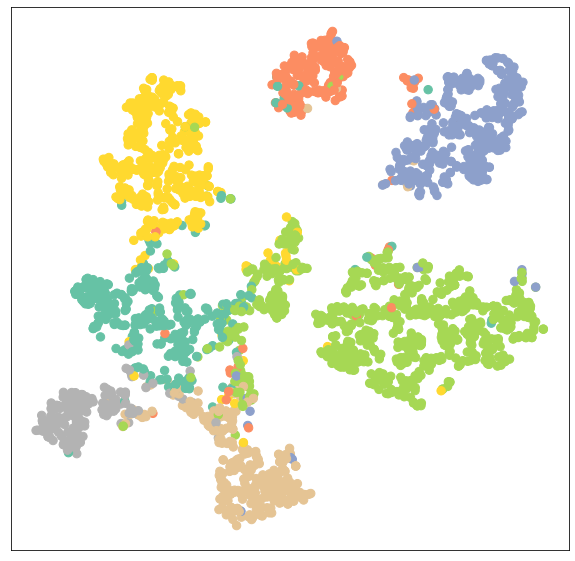

In [ ]:
out = GCN_Model(dataset_PGExplainer.x, dataset_PGExplainer.edge_index)
visualize(out, color=data.y)

In [ ]:
print(dataset_PGExplainer.keys)
print(len(dataset_PGExplainer.y[dataset_PGExplainer.train_mask]))
print(len(dataset_PGExplainer.y[dataset_PGExplainer.test_mask]))
print(len(dataset_PGExplainer.y[dataset_PGExplainer.val_mask]))
#dataset_PGExplainer.y[dataset_PGExplainer.train_mask]
print()
print(len(dataset_PGExplainer.x[dataset_PGExplainer.train_mask]))
print(len(dataset_PGExplainer.x[dataset_PGExplainer.test_mask]))
print(len(dataset_PGExplainer.x[dataset_PGExplainer.val_mask]))

print(len(dataset_PGExplainer.train_mask))
print(len(dataset_PGExplainer.test_mask))
print()
print(dataset_PGExplainer.train_mask)
print(dataset_PGExplainer.test_mask)
print(dataset_PGExplainer.val_mask)
print()
print(dataset_PGExplainer.edge_index)
print('===================================')
print(dataset_PGExplainer.x[dataset_PGExplainer.train_mask])



sum1=0
for i in dataset_PGExplainer.train_mask:
  if i:
    sum1 = sum1 + 1
print(sum1)

sum2=0
for i in dataset_PGExplainer.test_mask:
  if i:
    sum2 = sum2 + 1
print(sum2)

sum3=0
for i in dataset_PGExplainer.val_mask:
  if i:
    sum3 = sum3 + 1
print(sum3)



'''sum1=0
for i in data.train_mask:
  if i:
    sum1 = sum1 + 1
print(sum1)

sum2=0
for i in data.test_mask:
  if i:
    sum2 = sum2 + 1
print(sum2)

sum3=0
for i in data.val_mask:
  if i:
    sum3 = sum3 + 1
print(sum3)'''

['y', 'edge_index', 'val_mask', 'x', 'train_mask', 'test_mask']
1891
817
500

1891
817
500
2708
2708

tensor([False,  True,  True,  ..., False,  True, False])
tensor([ True, False, False,  ...,  True, False,  True])
tensor([False, False, False,  ..., False, False, False])

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1111,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
1891
817
500


'sum1=0\nfor i in data.train_mask:\n  if i:\n    sum1 = sum1 + 1\nprint(sum1)\n\nsum2=0\nfor i in data.test_mask:\n  if i:\n    sum2 = sum2 + 1\nprint(sum2)\n\nsum3=0\nfor i in data.val_mask:\n  if i:\n    sum3 = sum3 + 1\nprint(sum3)'